# Comparing results from SIMONA calculation against expectations of an ideal, loss-less transformer
Positive values in difference indicate higher values within SIMONA.

In [1]:
# ===== Read in both results =====
import json
import os
from collections import defaultdict
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt

from tcv.calculation.result import GridResultTwoWinding
from tcv.encoder import CustomDecoder
from tcv.encoder.DictEncoder import DictEncoder
from tcv.util import CsvFileWriter

result_directory = os.path.join("..", "..", "..", "..", "results", "two_winding")
simona_result_file = os.path.join(result_directory, "simona_tapHv.json")
diff_result_file = os.path.join(result_directory, "simona_vs_ideal_tapHv.json")
diff_csv_file = os.path.join("..", "..", "..", "..", "csv", "two_winding",
                             "%s_simona_vs_ideal_tapHv_diff.csv") % datetime.strftime(
    datetime.now(), "%Y%m%d")
rmse_csv_file = os.path.join("..", "..", "..", "..", "csv", "two_winding",
                             "%s_simona_vs_ideal_tapHv_rmse.csv") % datetime.strftime(
    datetime.now(), "%Y%m%d")

# --- SIMONA results ---
if os.path.exists(simona_result_file):
    # The result file exists. Read it and use it
    print("Pre-calculated SIMONA results are available. Load them.")
    with open(simona_result_file, "r") as file_to_read:
        json_string = file_to_read.read()
        simona_results = json.loads(json_string, object_hook=CustomDecoder.custom_decode)
else:
    raise IOError("Unable to gather results of SIMONA.")

# ===== Some important information =====
dv_pu = 2.5 / 100
tap_neutral = 0

# ===== Bring together both results =====
diff = []
p_lv_mw = []
for simona_result in simona_results:
    # Only register the input values in one tap position
    if simona_result['tap_pos'] == 0:
        p_lv_mw.append(simona_result['p_lv'])

    # Create the result for an ideal transformer
    tau = 1 + (simona_result['tap_pos'] - tap_neutral) * dv_pu
    v_lv_ideal_pu = 1.0 / tau
    ideal_result = GridResultTwoWinding.GridResultTwoWinding(v_lv_pu=v_lv_ideal_pu, v_ang_lv_degree=0.0,
                                                             p_hv_kw=simona_result['p_lv'], q_hv_kvar=0.0,
                                                             s_hv_kva=simona_result['p_lv'], i_mag_hv_a=0.0,
                                                             i_ang_hv_degree=0.0, p_lv_kw=simona_result['p_lv'],
                                                             q_lv_kvar=0.0, s_lv_kva=simona_result['p_lv'],
                                                             i_mag_lv_a=0.0, i_ang_lv_degree=0.0)

    diff.append({
        'tap_pos': simona_result['tap_pos'],
        'p_lv': simona_result['p_lv'],
        'result': GridResultTwoWinding.subtract(simona_result['result'], ideal_result)
    })

# ===== Write results, if not yet done =====
if not os.path.exists(diff_result_file):
    with open(diff_result_file, "w") as file_to_write_to:
        print("Writing diff to file")
        json.dump(diff, file_to_write_to, cls=DictEncoder, indent=2)

if not os.path.exists(diff_csv_file):
    CsvFileWriter.write_for_pgf_line_plot(p_lv_tick_num=21, p_lv_rated_mw=0.63, tap_range=range(-10, 11),
                                          result_json_path=diff_result_file, csv_file_path=diff_csv_file, col_sep=",")

# ===== Group results by tap position =====
tap_to_diff = defaultdict(list)
for d in diff:
    tap_to_diff[d['tap_pos']].append(d)

Pre-calculated SIMONA results are available. Load them.
Writing diff to file


## Visualize the error

Tap dependent voltage deviation

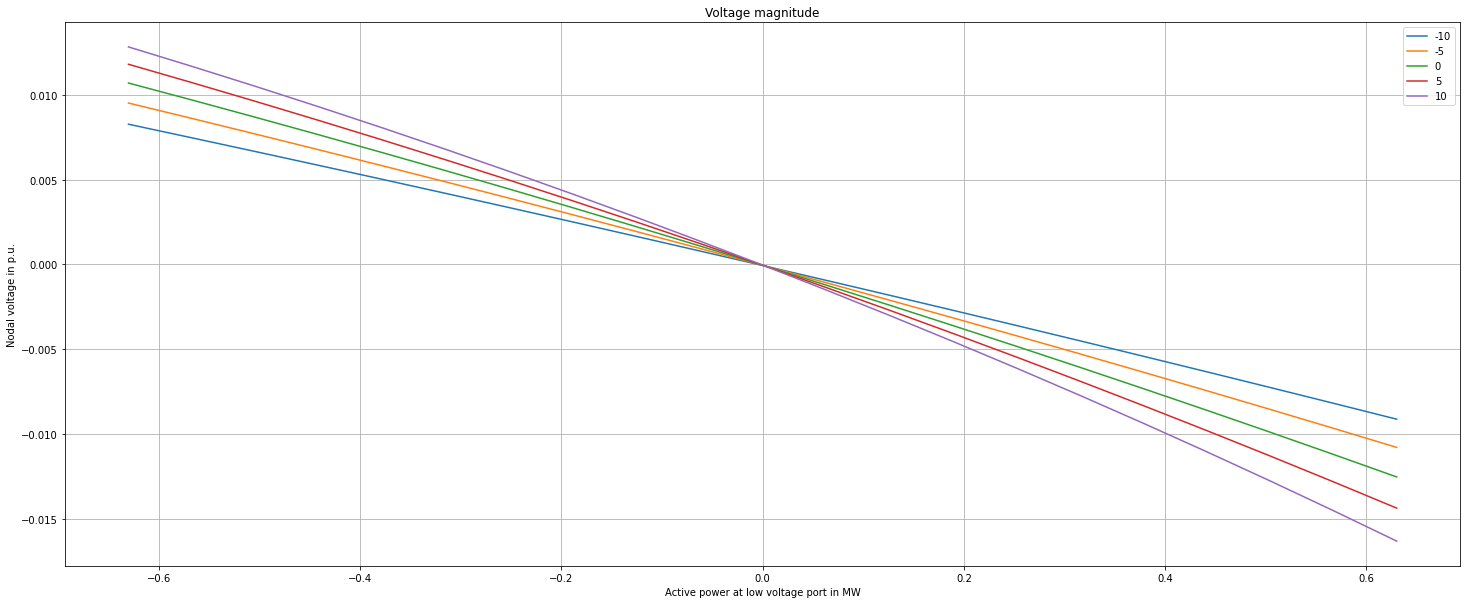

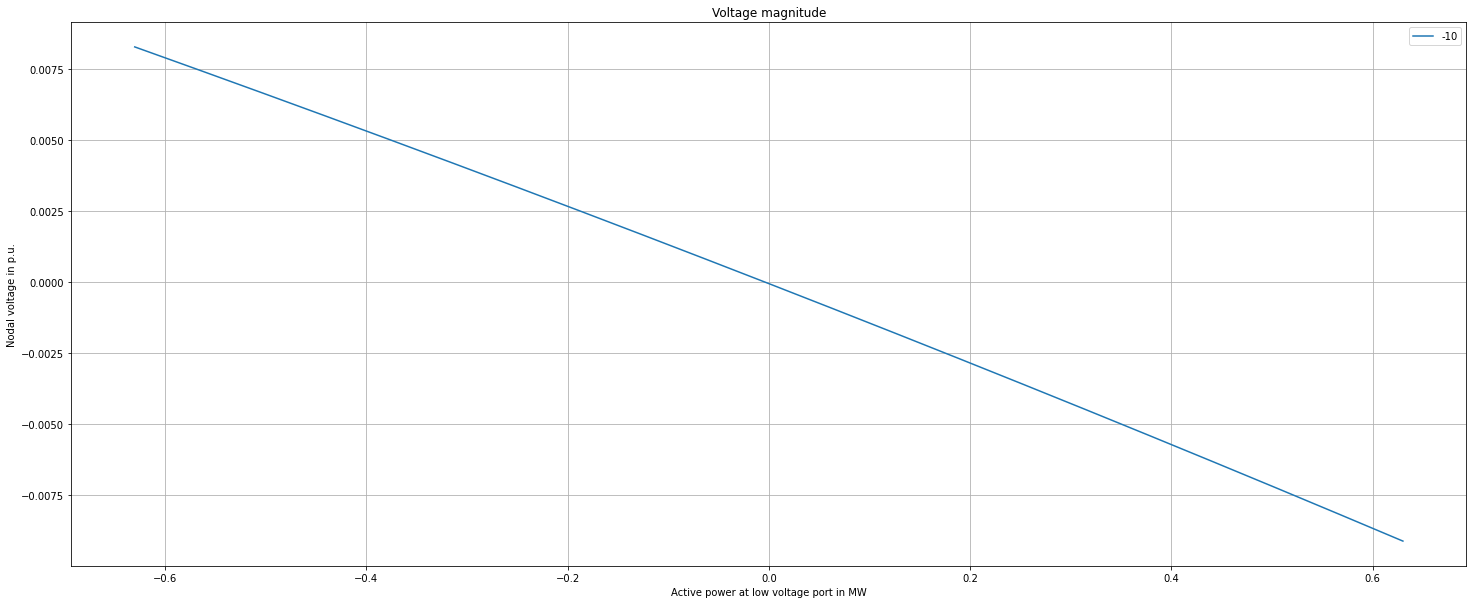

In [2]:
fig_tap_mag, ax_tap_mag = plt.subplots(figsize=(25, 10))
ax_tap_mag.set_title('Voltage magnitude')
ax_tap_mag.set_xlabel('Active power at low voltage port in MW')
ax_tap_mag.set_ylabel('Nodal voltage in p.u.')
ax_tap_mag.grid()
ax_tap_mag.plot(np.array(p_lv_mw), np.array(list(map(lambda r: r['result'].v_lv_pu, tap_to_diff[-10]))), label='-10')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(list(map(lambda r: r['result'].v_lv_pu, tap_to_diff[-5]))), label='-5')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(list(map(lambda r: r['result'].v_lv_pu, tap_to_diff[0]))), label='0')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(list(map(lambda r: r['result'].v_lv_pu, tap_to_diff[5]))), label='5')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(list(map(lambda r: r['result'].v_lv_pu, tap_to_diff[10]))), label='10')
ax_tap_mag.legend()

fig_tap_mag_10, ax_tap_mag_10 = plt.subplots(figsize=(25, 10))
ax_tap_mag_10.set_title('Voltage magnitude')
ax_tap_mag_10.set_xlabel('Active power at low voltage port in MW')
ax_tap_mag_10.set_ylabel('Nodal voltage in p.u.')
ax_tap_mag_10.grid()
ax_tap_mag_10.plot(np.array(p_lv_mw), np.array(list(map(lambda r: r['result'].v_lv_pu, tap_to_diff[-10]))), label='-10')
ax_tap_mag_10.legend()